# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

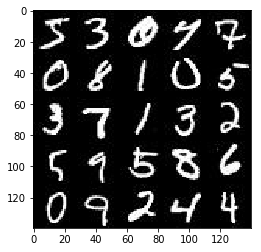

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

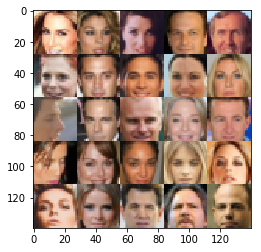

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    drop = 0.9
    with tf.variable_scope('discriminator', reuse=reuse):
        
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*layer1, layer1)
        drop1 = tf.nn.dropout(relu1, drop)
        # 14x14x64
        
        layer2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        drop2 = tf.nn.dropout(relu2, drop)
        #7x7x128
        
        layer3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        drop3 = tf.nn.dropout(relu3, drop)
        #4x4x256
        
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_dim
        
        out = tf.tanh(logits)
        
        return out/2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    channle_dim = 1
    if (data_image_mode == 'RGB'):
        channle_dim = 3
    input_real, input_z, learn_rate = model_inputs(28, 28, channle_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channle_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    n_step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                n_step = n_step + 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                _= sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _= sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                if (n_step % 10 == 0):
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if (n_step % 100 == 0):
                    show_generator_output(sess, batch_size, tf.convert_to_tensor(batch_z, dtype=tf.float32), channle_dim, data_image_mode)
                    

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.6054... Generator Loss: 8.7610
Epoch 1/2... Discriminator Loss: 0.4797... Generator Loss: 14.8722
Epoch 1/2... Discriminator Loss: 0.4974... Generator Loss: 3.4374
Epoch 1/2... Discriminator Loss: 1.7063... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 1.2072
Epoch 1/2... Discriminator Loss: 0.4068... Generator Loss: 4.7287
Epoch 1/2... Discriminator Loss: 0.6545... Generator Loss: 1.8170
Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 2.3089
Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 3.0431
Epoch 1/2... Discriminator Loss: 0.7934... Generator Loss: 2.1097


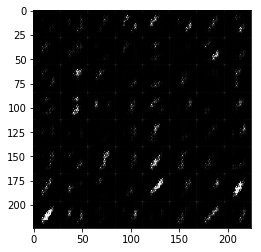

Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 3.1854
Epoch 1/2... Discriminator Loss: 0.7753... Generator Loss: 1.9873
Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 2.5103
Epoch 1/2... Discriminator Loss: 0.8861... Generator Loss: 1.4772
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 1.3884
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 1.4874... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 0.9497... Generator Loss: 2.1568
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 1.4922
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.9958


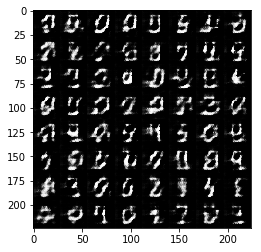

Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 2.2110
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.3320... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 2.0078... Generator Loss: 0.3621
Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 1.2078
Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 1.2133
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 1.7954
Epoch 1/2... Discriminator Loss: 1.5369... Generator Loss: 0.5615
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 0.9291


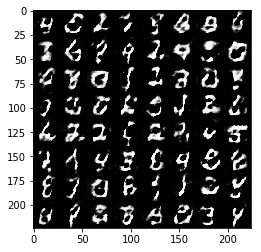

Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 1.0965
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 1.7040
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.7378
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.9604
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 1.9686
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 1.3223
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 1.3272


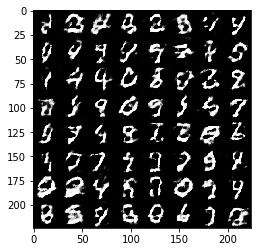

Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 1.9293
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 1.5294
Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 1.5640
Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 1.6243
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.8972
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 1.1672
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 1.3190
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 1.6589


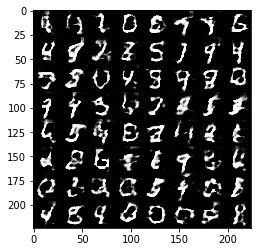

Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 1.1115
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 1.7703
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 1.4167
Epoch 1/2... Discriminator Loss: 1.1880... Generator Loss: 1.2642
Epoch 1/2... Discriminator Loss: 1.4177... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.5827
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 2.3249


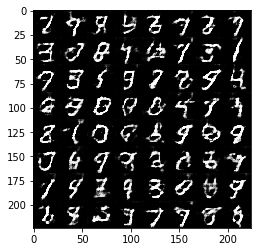

Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 0.8183
Epoch 1/2... Discriminator Loss: 1.4282... Generator Loss: 1.8706
Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 1.6317
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 1.4141
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 0.9213
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.1344
Epoch 1/2... Discriminator Loss: 1.4662... Generator Loss: 0.6269
Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 1.5069
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.9908


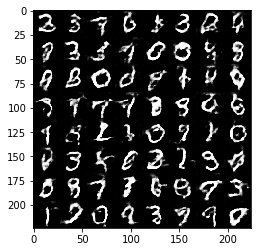

Epoch 1/2... Discriminator Loss: 1.1007... Generator Loss: 0.9548
Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 1.3940
Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.1620
Epoch 1/2... Discriminator Loss: 1.1909... Generator Loss: 1.1802
Epoch 1/2... Discriminator Loss: 1.0323... Generator Loss: 0.9601
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 1.3630
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 1.3123
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.6579


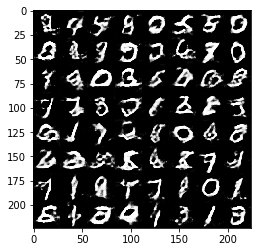

Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 1.1304
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 1.2121
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 1.8791
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.4361
Epoch 1/2... Discriminator Loss: 1.6914... Generator Loss: 0.5442
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.9458
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 1.4548
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 1.3986
Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 1.4762


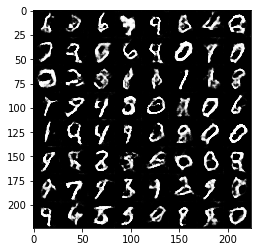

Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.9126
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 1.0654... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 1.1055
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.4022
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 1.0840
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 1.0589
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 0.6662


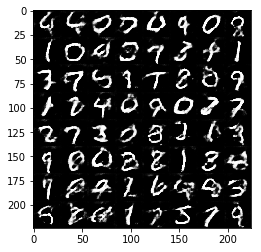

Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 1.2777
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 1.2661
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.0198
Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 0.9594
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 1.3244
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 1.0243
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 1.8246
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.4551
Epoch 2/2... Discriminator Loss: 1.0595... Generator Loss: 0.8717


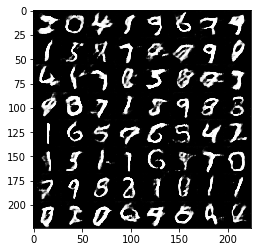

Epoch 2/2... Discriminator Loss: 0.9101... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 1.5018
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 1.0687
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 1.0540
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.0180
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 0.4966
Epoch 2/2... Discriminator Loss: 0.9935... Generator Loss: 1.4370
Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 1.0377


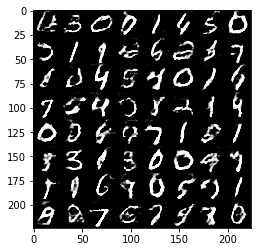

Epoch 2/2... Discriminator Loss: 0.8772... Generator Loss: 1.4069
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 2.6450
Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 1.1601
Epoch 2/2... Discriminator Loss: 1.1650... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 0.9644
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 2.5871
Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 0.9317
Epoch 2/2... Discriminator Loss: 1.7146... Generator Loss: 0.4214
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 1.5164
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 2.6141


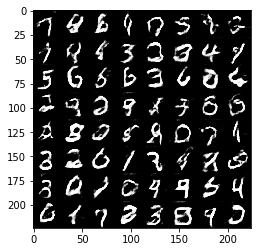

Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 1.1477
Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 1.6352
Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.0051... Generator Loss: 0.9995
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 1.2543
Epoch 2/2... Discriminator Loss: 0.9000... Generator Loss: 1.9060
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.5248
Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 1.6322
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 2.4769


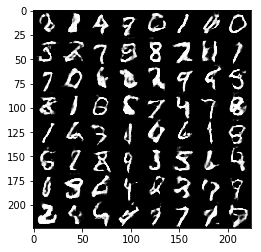

Epoch 2/2... Discriminator Loss: 1.5889... Generator Loss: 0.5664
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.4782
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.6825
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 1.4311
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.1224
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 1.0506
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 1.0237
Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 0.7548


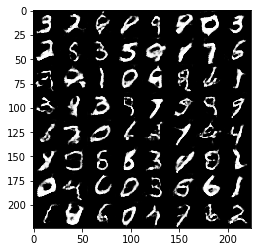

Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 1.0639
Epoch 2/2... Discriminator Loss: 1.2833... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.8330
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 0.9612
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.1916
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 0.9649... Generator Loss: 2.8437
Epoch 2/2... Discriminator Loss: 1.7973... Generator Loss: 0.3590
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 1.5825


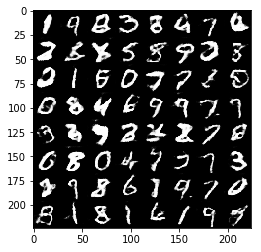

Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 1.4014
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.8334
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 1.6805
Epoch 2/2... Discriminator Loss: 1.7353... Generator Loss: 0.5270
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 1.0443
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.1088
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.3984
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 1.5835... Generator Loss: 0.4638


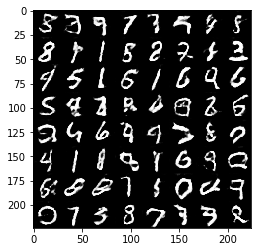

Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 1.4248
Epoch 2/2... Discriminator Loss: 0.8778... Generator Loss: 1.6467
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.9079
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 1.8045
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 2.0440
Epoch 2/2... Discriminator Loss: 0.8742... Generator Loss: 1.1911
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 1.2198
Epoch 2/2... Discriminator Loss: 1.5067... Generator Loss: 0.5160
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 1.2286
Epoch 2/2... Discriminator Loss: 1.4976... Generator Loss: 0.6808


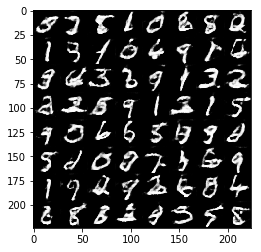

Epoch 2/2... Discriminator Loss: 1.2978... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.4008
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 1.1460
Epoch 2/2... Discriminator Loss: 0.8121... Generator Loss: 1.1851
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.6886


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.3880
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.5264
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.9877
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.6323
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 3.0151


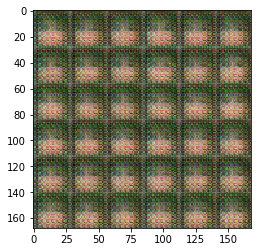

Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.7520
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.9151
Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 3.0278
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 3.6643
Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 2.1454
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 2.4764
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 3.2026
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 3.0710
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 2.9843


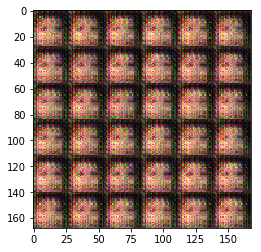

Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 3.8515
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 3.6537
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 4.0283
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 3.8478
Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 2.7178
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 3.0064
Epoch 1/1... Discriminator Loss: 0.5745... Generator Loss: 3.0388
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 3.6979
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 3.3429
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 3.5204


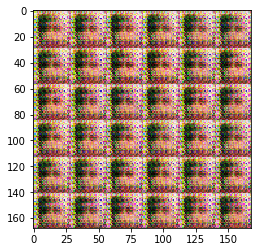

Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 3.7354
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.4220
Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 4.3010
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 3.4293
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 3.2119
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 3.1708
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 3.6564
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 4.4747
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 4.2268
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 3.1905


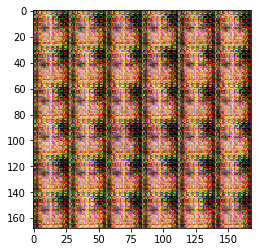

Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 3.7877
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 3.9910
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 2.2121
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 2.3383
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.6689
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 2.3031
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 2.1886
Epoch 1/1... Discriminator Loss: 0.5745... Generator Loss: 2.6364
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.6111
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 3.0076


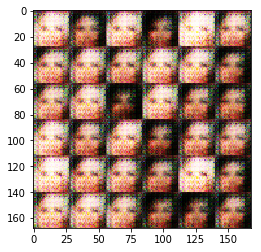

Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.5742
Epoch 1/1... Discriminator Loss: 0.4922... Generator Loss: 2.9905
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 2.1419
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 3.2132
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 2.0738
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 2.2914
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 2.5659
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 2.6973
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 2.6891


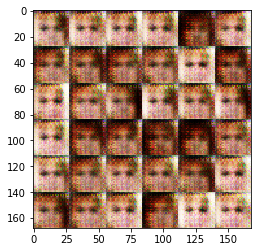

Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 2.5480
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 2.0775
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.7255
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 1.9763
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.4460
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.7351
Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 2.3059
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.8382
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.4682
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.4327


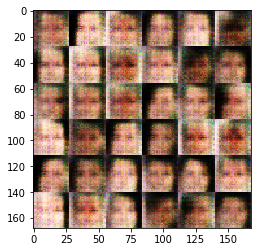

Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 2.3940
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.6368
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.5894
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.7671
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.2688
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 1.6515
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 2.1877
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.8860


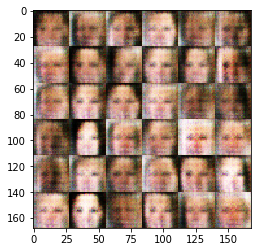

Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.6992
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.5897
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.5348
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 1.6600
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 2.0376
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.4479
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 1.6952
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.9641


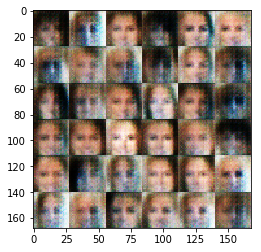

Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.6523
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.7960
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 2.0815
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.8920
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.6304


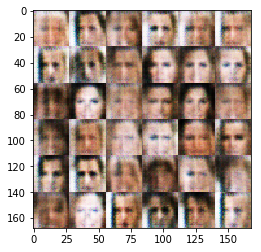

Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.3864
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 2.8861
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.6969
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.6776
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.5815
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 2.1103
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.5267


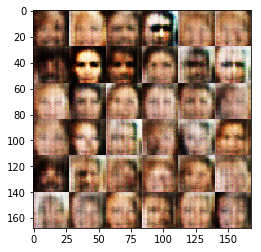

Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.3508
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.9546
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.9467
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.7343
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.0941


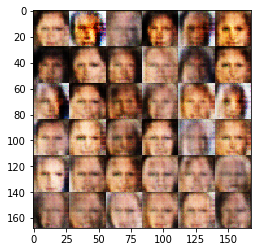

Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 1.7812
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.4677
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 2.2534
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 1.7032


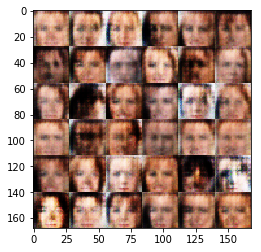

Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.8138
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.6645
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.2029
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.4464
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 1.5835
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.9893


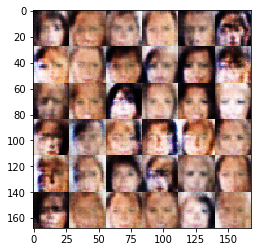

Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.1858
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.0447


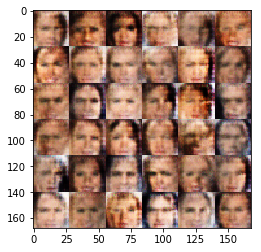

Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.2383
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.1559
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.7771
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.6348
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.8343


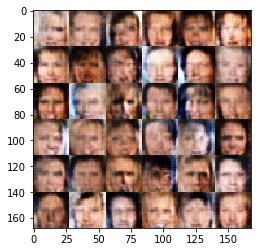

Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.4179
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.5616


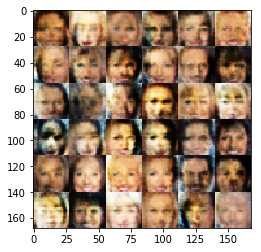

Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.5229
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.2581
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.4145


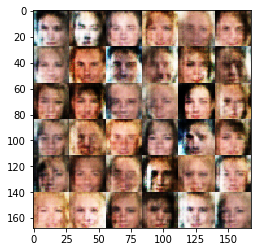

Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.6088
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.7802


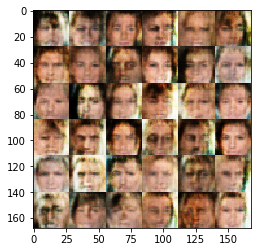

Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.6935
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.2995
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 1.1303


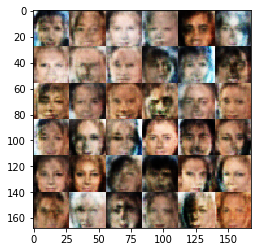

Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.4536
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.3759
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.2640


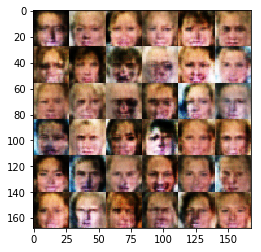

Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.4062
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.4174


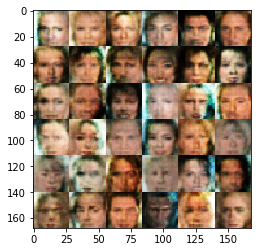

Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.8255
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7441


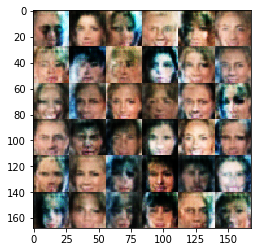

Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.4120


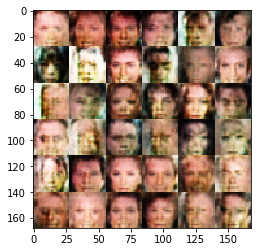

Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.3219
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 1.1674
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7581


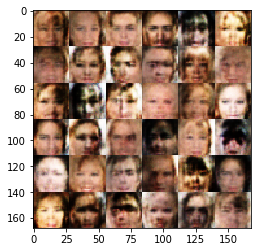

Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.2908
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.9144
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.4073
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.1840


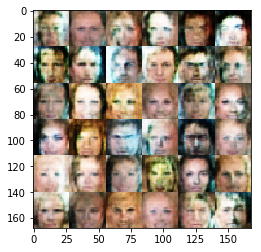

Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.3470
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.6995... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 1.4564


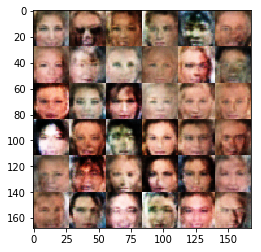

Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.2376
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.2083


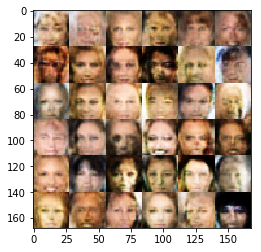

Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.2038


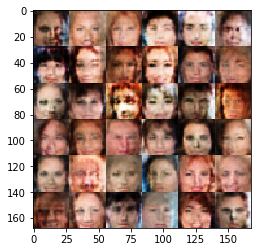

Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.5748
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.1445
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.4680
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 1.4085
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.0405


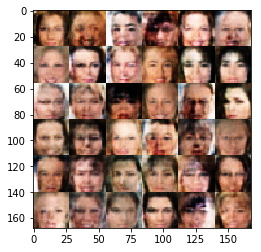

Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.4808
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.9269


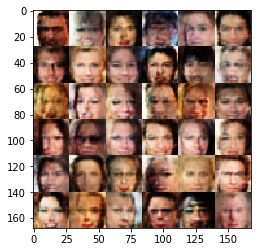

Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.4167
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 1.1720
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.4832


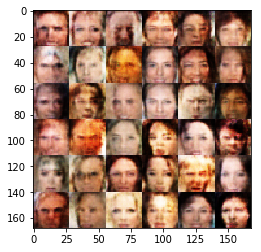

Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 1.2145
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.4636
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.4433
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.2568
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.4589


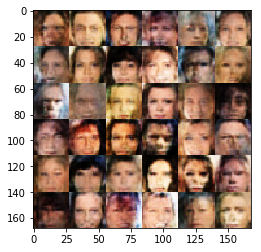

Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.5397
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.4257
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.1446


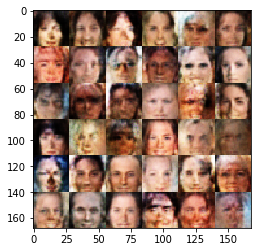

Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.4660


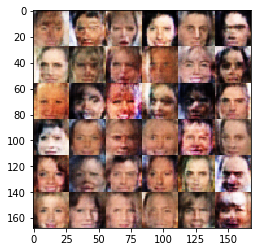

Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.7502
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.1575


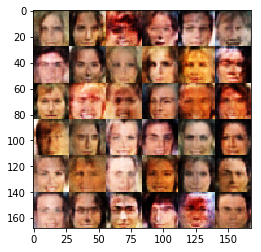

Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.3787
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.0174


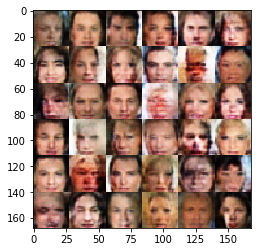

Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.5192
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.3376
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.0837


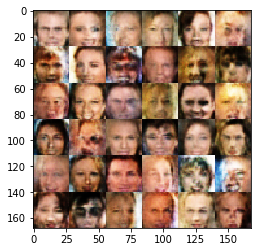

Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.3516
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.9263


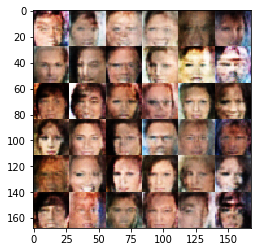

Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.7680
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.1963
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.0505


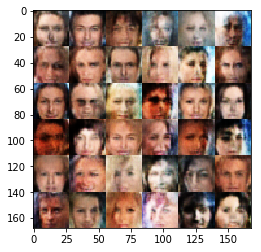

Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 1.0860


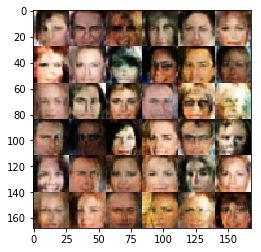

Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.2960
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.0036


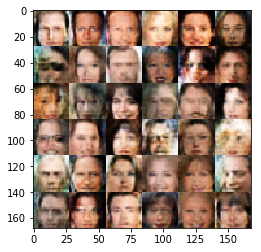

Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.4044
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.1966


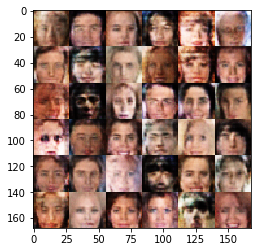

Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.6234
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.5504
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 1.1103


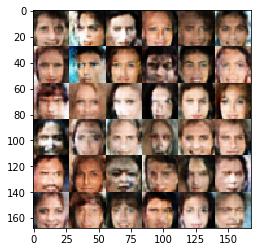

Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.2706
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.1317


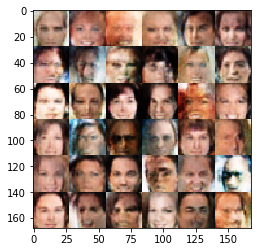

Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.2008
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 1.3194


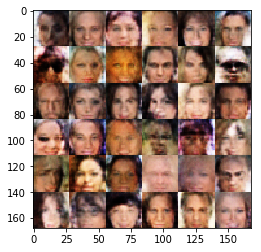

Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9132


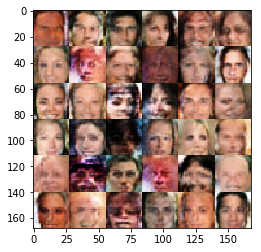

Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.4794
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.3165
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.5851
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.9689


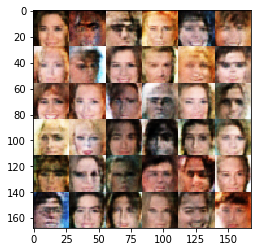

Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 1.0531


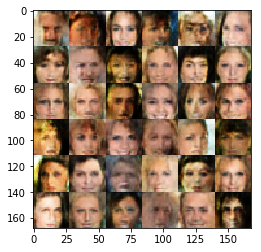

Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8953


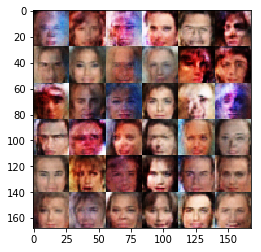

Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.4206
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.1607


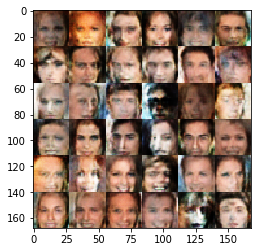

Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 1.1040


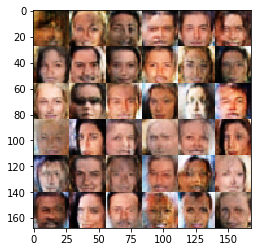

Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 1.5724
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.5928
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.3629
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.2861
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 1.8062
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.1025


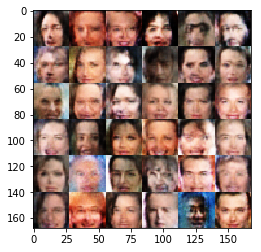

Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 1.3917
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.2868


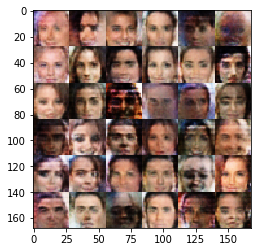

Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.1926


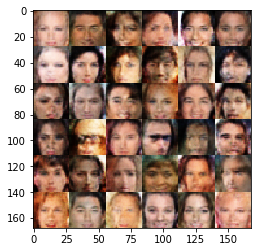

Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.3265
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.8669


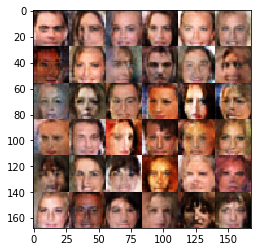

Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.9961


In [21]:
batch_size = 36
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。